# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [140]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [141]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

##  Data Exploration

#### 1. Portfolio data

In [142]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [143]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [144]:
# check no. of unique offers
print("No. of unique offers: {}".format(portfolio.id.nunique()))

# no. of unique offers by offer type
print(portfolio.groupby('offer_type')['id'].count())

No. of unique offers: 10
offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64


#### 2. Demographic data

In [145]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [146]:
print(profile.isnull().sum())
print("no. unique people: {}".format(profile['id'].nunique()))

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64
no. unique people: 17000


age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64
  gender  income  age
0   None     NaN  118
2   None     NaN  118
4   None     NaN  118
6   None     NaN  118
7   None     NaN  118


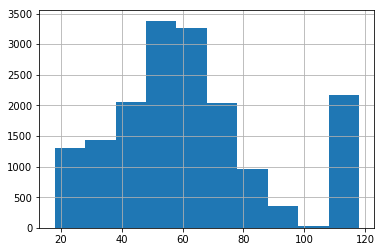

In [147]:
profile.age.hist()
print(profile[profile['age'] == 118].count())
print(profile[['gender','income','age']][profile['age']==118].head())

#### 3. Transactional records

In [148]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [149]:
print(transcript.event.unique())
print("no. unique people: {}".format(transcript['person'].nunique()))

['offer received' 'offer viewed' 'transaction' 'offer completed']
no. unique people: 17000


In [150]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [151]:
# expand the value into individual columns depending on the even
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)],axis=1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [152]:
#create new column to ensure only one offer_id column
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

#drop unnecessary offer_id columns
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename offer_id column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

transcript.head()

,event,person,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


## Data preprocessing

#### 1. Assigning offer ids to transactions

In [153]:
# explore kind of events within each offer type
portfolio.rename(columns={'id':'offer_id'},inplace=True)

#join transcript with offer type
transcript=transcript.merge(portfolio, how='left',on='offer_id')

In [154]:
transcript[transcript['event'] == 'transaction'].head()

,event,person,time,value,amount,reward_x,offer_id,channels,difficulty,duration,offer_type,reward_y
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001},0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56},34.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23},13.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51},19.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97},18.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
transcript.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

In [156]:
# drop unnecessay columns in transcript 
transcript = transcript.drop(columns=['reward_x','reward_y'],axis=1,inplace=False)
# sort events by person and time
transcript = transcript.sort_values(['person','time'])

In [157]:
# forward fill offer ides by person for transactions that occur after an offer is viewed
offers_view_transacted = transcript[['time','offer_id','person','event']][(transcript['event']=='transaction') | (transcript['event']=='offer viewed')].groupby(['person','offer_id']).ffill()
offers_view_transacted['offer_id']=offers_view_transacted['offer_id'].ffill()

In [158]:
offers_view_transacted.head()

,person,offer_id,time,event
77705,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192,offer viewed
89291,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,228,transaction
139992,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372,offer viewed
168412,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,414,transaction
187554,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456,offer viewed


In [159]:
transcript = transcript.merge(offers_view_transacted,how = 'left', on = ['person','time','event'])

In [160]:
#clean up dataset to unify multiple offer_id columns into one column
transcript['offer_id']=np.where(transcript['offer_id_x'].isnull(),transcript['offer_id_y'],transcript['offer_id_x'])

transcript = transcript.drop(columns = ['offer_id_x','offer_id_y'],axis=1,inplace=False)

In [161]:
transcript.head()

,event,person,time,value,amount,channels,difficulty,duration,offer_type,offer_id
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed


In [162]:
#merge portfolio dataset to get offer data for the transaction events
transcript=transcript.merge(portfolio,how='left',on='offer_id')
transcript['duration']=np.where(transcript['duration_x'].isnull(),transcript['duration_y'],transcript['duration_x'])
tanscript = transcript.drop(['duration_x','offer_type_x','difficulty_x','channels_x','duration_y'],axis=1,inplace=True)
transcript.rename(columns={'channels_y':'channels','reward_y':'reward','difficulty_y':'difficulty','offer_type_y':'offer_type'},inplace=True)

In [163]:
transcript.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0


#### 2. Flagging transactions and offers completed after offers viewed

In [164]:
offers_viewed_transactions_completed=transcript[(transcript['event']=='offer viewed') | (transcript['event']=='transaction') | (transcript['event']=='offer completed')].copy()

In [165]:

#add extra column to flag the previous offer id
offers_viewed_transactions_completed['offer_id_previous'] = offers_viewed_transactions_completed.groupby(['person','offer_id'])['offer_id'].shift()
offers_viewed_transactions_completed.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,offer_id_previous
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN
6,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57},8.57,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,3f207df678b143eea3cee63160fa8bed
7,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN


In [166]:
#flag a completed transaction/offer completed as long as the previous offer id consists of events in the same sample space
offers_viewed_transactions_completed['valid_completed']=np.where(offers_viewed_transactions_completed['offer_id_previous']==offers_viewed_transactions_completed['offer_id'],1,0)
offers_viewed_transactions_completed.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,offer_id_previous,valid_completed
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,0
6,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57},8.57,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,3f207df678b143eea3cee63160fa8bed,1
7,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,0


In [167]:
#get only offer received events
offers_received=transcript[transcript['event']=='offer received'].copy()

#ensure all columns are the same between datasets to be appended
offers_received['offer_id_previous']=np.nan
offers_received['valid_completed']=np.nan

#append datasets to complete dataset of transactions
transcript=offers_received.append(offers_viewed_transactions_completed)

#sort values
transcript=transcript.sort_values(['person','time'])
transcript.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,offer_id_previous,valid_completed
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,0.0


In [168]:
#define function to split into 3 offer types
def split(offer_type,grp_df):
    '''
    Splits dataframe to groups of specified offer type.
    
    inputs:
    - offer_type: specify offer type name in string format 
    - grp_df: original transcript dataframe to split on offer type
    
    outputs:
    - Returns dataframe containing data of just offer type.
       
    '''
    df=grp_df[grp_df['offer_type']==offer_type].copy()
    return df

#split transcript into 3 different offer types
transcript_bogo=split('bogo',transcript)
transcript_discount=split('discount',transcript)
transcript_info=split('informational',transcript)

In [169]:
#since will do this for both BOGO and discount, define function for repeated operation
def grp1(df):
    '''
    Subsets dataframe to just group 1 members.
    
    inputs:
    - df: original transcript dataframe 

    outputs:
    - Returns dataframe containing transcript data of just group 1 users.
       
    '''
    grp1=df[['person','offer_id']][(df['valid_completed']==1) & (df['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()
    return grp1

grp1_bogo=grp1(transcript_bogo)
grp1_discount=grp1(transcript_discount)

In [170]:
#again, we define a function as we will repeat this for 2 datasets - BOGO & discount
def no_conv(df):
    
    '''
    Takes in transcript dataframe of single offer type to check for people who converted vs people with just offer received events. 
    
    inputs:
    - df: original transcript dataframe of specific offer type 
    
    outputs:
    - Returns dataframe containing unqiue person-offer_id pairs with conversion events and offers received events, with indicator of each.
    
    Note: left_only indicator is just the offers received events, right_only is just conversion events
       
    '''
    
    #subset offer ids that have transactions or conversions by person and offer_id
    conversion_ids=df[['person','offer_id']][(df['event']=='transaction') | (df['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()
    
    #check for unique person-offer_id pairs that consist of offers received 
    offers_received_only=df[['person','offer_id']][df['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()

    #create merged dataset to diffrentiate groups
    check_merge=conversion_ids.merge(offers_received_only,how='right',on=['person','offer_id'],indicator=True)
    return check_merge

In [171]:
#check how many are in either group
check_merge_bogo=no_conv(transcript_bogo)
print('For BOGO offers:')
print(check_merge_bogo.groupby(['_merge']).count())

check_merge_discount=no_conv(transcript_discount)
print('For Discount offers:')
print(check_merge_discount.groupby(['_merge']).count())

For BOGO offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    4729      4729
both         20592     20592
For Discount offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    6415      6415
both         18901     18901


In [172]:
def grp_2_4(df):
    
    '''
    Takes in output dataframe from no_conv function to split into group 2 and 4 customers.
    
    inputs:
    - df: output dataframe from no_conv function
    
    outputs:
    - Returns 2 dataframes containing unique person-offer_id pairs with dataframe containing only group2 customers first, followed by dataframe containing only group 4 customers. 
       
    '''
    
    #subset to check group 2 and 4
    grp_2_4=df[df['_merge']=='right_only'] # only received

    #remerge with transcript to get events
    grp_2_4=grp_2_4.merge(transcript,how='left',on=['person','offer_id'])

    #within this subset, separate people with offer viewed event, and people with offer received but no offer viewed
    grp2=grp_2_4[['person','offer_id']][grp_2_4['event']=='offer viewed'].groupby(['person','offer_id']).count().reset_index() #received and viewed

     #remerge with full dataset and get remaining to get grp4
    grp_2_4.drop(['_merge'],axis=1,inplace=True)
    grp4 = grp_2_4.merge(grp2[['person','offer_id']],how='left',indicator=True)
    grp4 = grp4[grp4['_merge']=='left_only'].copy() # received no viewed
    
    return grp2,grp4

grp2_bogo,grp4_bogo=grp_2_4(check_merge_bogo)
grp2_discount,grp4_discount=grp_2_4(check_merge_discount)

In [173]:
def grp3(df):
    '''
    Takes in transcript dataframe of single offer type to check for people who complete regardless of received/viewed offer
    
    inputs:
    - df: original transcript dataframe of specific offer type 
    
    outputs:
    - Returns dataframe containing unqiue person-offer_id pairs with conversion events and offers received events, with indicator of each.
       
    '''
    
    #check all conversion events with invalid conversions
    grp3=df[['person','offer_id']][(df['event']=='offer completed') & (df['valid_completed']!=1)].groupby(['person','offer_id']).count().reset_index()
    return grp3

grp3_bogo=grp3(transcript_bogo)
grp3_discount=grp3(transcript_discount)

In [174]:
def offers(grp1,grp2):
    '''
    inputs:
    - grp1: dataframe containing group1 customer data 
    - grp2: dataframe containing group2 customer data
    
    outputs:
    - Returns dataframe with labeled effective offer column
    '''
    #assign effective offer flag column
    grp1['effective_offer']=1
    grp2['effective_offer']=0

    #append datasets together
    offers=grp1.append(grp2,sort=False)
    return offers

offers_bogo=offers(grp1_bogo,grp2_bogo)
offers_discount=offers(grp1_discount,grp2_discount)

#### 3. consider validity of offers in converted transactions from informational offers

In [175]:
# convert time into days
transcript_info['day_offer'] = transcript_info['time']/24

# drop unnecessary columns
transcript_info.drop(['time','value','offer_id_previous'],axis=1,inplace=True)

# sort transcript to ensure all event occurring by person and offer
transcript_info = transcript_info.sort_values(['person','day_offer','event','offer_id'])

In [176]:
transcript_info['diff_info'] = transcript_info[(transcript_info['event'] == 'offer received') | (transcript_info['event'] == 'transaction')].groupby(['person','offer_id'])['day_offer'].diff()
transcript_info.head()

,event,person,amount,offer_id,channels,difficulty,offer_type,reward,duration,valid_completed,day_offer,diff_info
0,offer received,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,7.0,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,0.0,8.0,NaN
2,transaction,0009655768c64bdeb2e877511632db8f,22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,1.0,9.5,2.5
3,offer received,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,14.0,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,0.0,15.5,NaN


In [177]:
#create column for flagging valid events
transcript_info['valid_completed_duration']=np.nan

#flag valid events if within duration
transcript_info.loc[transcript_info['diff_info']<=transcript_info['duration'],'valid_completed_duration']=1

#fill any missing values with 0 flag
transcript_info['valid_completed_duration']=transcript_info['valid_completed_duration'].fillna(value=0)

In [178]:
transcript_info['effective_offer'] = np.where(((transcript_info['valid_completed'] == 1) & (transcript_info['valid_completed_duration'] == 1)),1,0)

In [179]:
#separate group 1 in transcript_into
grp1_info=transcript_info[['person','offer_id']][transcript_info['effective_offer']==1].groupby(['person','offer_id']).sum().reset_index()


In [180]:
#separate out group 2 of customers
check_merge_info=no_conv(transcript_info)
print('For informational offers:')
print(check_merge_info.groupby(['_merge']).count())

grp2_info,grp4_info=grp_2_4(check_merge_info)

For informational offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    5412      5412
both          7239      7239


In [181]:
#scenario 1
grp3_1=transcript_info[['person','offer_id']][(transcript_info['event']=='transaction')&(transcript_info['valid_completed']!=1) & (transcript_info['valid_completed_duration']==1)].groupby(['person','offer_id']).count().reset_index()
#scenario 2
grp3_2=transcript_info[['person','offer_id']][(transcript_info['event']=='transaction')&(transcript_info['valid_completed']==1) & (transcript_info['valid_completed_duration']!=1)].groupby(['person','offer_id']).count().reset_index()
grp3_info=grp3_1.append(grp3_2,sort=False)
del grp3_1
del grp3_2

In [182]:
offers_info=offers(grp1_info,grp2_info)

## Feature Engineering

#### 1. count of offers received

person
0009655768c64bdeb2e877511632db8f    5
00116118485d4dfda04fdbaba9a87b5c    2
0011e0d4e6b944f998e987f904e8c1e5    5
0020c2b971eb4e9188eac86d93036a77    5
0020ccbbb6d84e358d3414a3ff76cffd    4
Name: event, dtype: int64


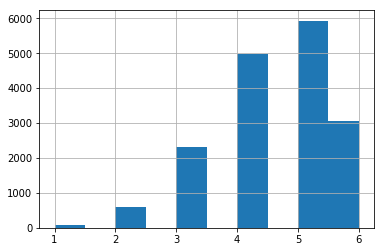

In [183]:
#group event=offer received per person in transactional records
print(transcript[transcript['event']=='offer received'].groupby('person')['event'].count().head())

#visualise offers received per person
transcript[transcript['event']=='offer received'].groupby('person')['event'].count().hist()

In [184]:
#get count of offers received per person, put into separate dataset
df_offer_received_cnt=transcript[transcript['event']=='offer received'].groupby(['person','offer_id','time']).count()['event'].reset_index()

#rename columns
df_offer_received_cnt.rename(columns={'event':'offer_received_cnt'},inplace=True)

#drop unnecessary columns
df_offer_received_cnt.drop('time',axis=1,inplace=True)

# ensure only unique person-offer_id pairs
df_offer_received_cnt=df_offer_received_cnt.groupby(['person','offer_id']).sum().reset_index()
df_offer_received_cnt.head()

,person,offer_id,offer_received_cnt
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1


#### 2. separating user behavious by transactions

In [185]:
#filter dataset by invalid transactions
df_transactions_invalid=transcript[(transcript['event']=='transaction') & (transcript['valid_completed']==0)].groupby(['person','offer_id'])['amount'].sum().reset_index()
df_transactions_invalid.rename(columns={'amount':'amount_invalid'},inplace=True)
df_transactions_invalid.head()

,person,offer_id,amount_invalid
0,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,16.27
1,004b041fbfe44859945daa2c7f79ee64,fafdcd668e3743c1bb461111dcafc2a4,25.62
2,0063def0f9c14bc4805322a488839b32,2298d6c36e964ae4a3e7e9706d1fb8c2,2.76
3,0069a50874d846438e58acff5e594725,0b1e1539f2cc45b7b9fa7c272da2e1d7,16.20
4,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,27.26


#### 3. became_membe_on column to be engineered. 
how long someone has been a member,with whether he takes up an offer

In [186]:

#rename column for merging
profile.rename(columns={'id':'person'},inplace=True)

#create function to reuse for 3 datasets
def member(df):
    '''
    inputs:
    - df: original dataframe to transform became_member_on column  
    
    outputs:
    - Returns dataframe with became_member_on column transformed to be tenure in days
    
    '''
    #merge to get user demographic profile
    df=df.merge(profile,how='left',on='person')
    
    #convert became_member_on into member tenure
    df['year']=pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
    df['month']=pd.Series([int(str(x)[-3]) for x in df['became_member_on']])
    df['day']=pd.Series([int(str(x)[-2:]) for x in df['became_member_on']])
    df.drop('became_member_on',axis=1,inplace=True)
    df.loc[df['year'] == 2018, 'membership_tenure_days'] = (30*df['month'])+df['day']
    df.loc[df['year'] != 2018, 'membership_tenure_days'] = ((2018-df['year'])*365)+(30*df['month'])+df['day']
    df.drop(['year','month','day'],axis=1,inplace=True)
    
    return df

offers_bogo=member(offers_bogo)
offers_discount=member(offers_discount)
offers_info=member(offers_info)

## Preparing data 

#### 1. merge engineered featured to original dataframe

In [187]:
#merge to get offers received count and invalid amount transacted 
offers_bogo=offers_bogo.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
offers_bogo=offers_bogo.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

In [188]:
(offers_bogo.isnull().sum()/len(offers_bogo) * 100).sort_values(ascending=False).head()

amount_invalid            96.323752
income                     7.057489
gender                     7.057489
offer_received_cnt         0.000000
membership_tenure_days     0.000000
dtype: float64

In [189]:
#fill missing values for amount_invalid with 0
offers_bogo['amount_invalid']=offers_bogo['amount_invalid'].fillna(value=0)

#drop income and gender null rows
offers_bogo.dropna(inplace=True)

#merge with portfolio to get offer details
offers_bogo=offers_bogo.merge(portfolio,how='left',on='offer_id')

In [190]:
offers_bogo.head()

,person,offer_id,effective_offer,age,gender,income,membership_tenure_days,offer_received_cnt,amount_invalid,channels,difficulty,duration,offer_type,reward
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,O,57000.0,39.0,1,0.0,"[web, email, mobile]",5,7,bogo,5
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,F,90000.0,824.0,1,0.0,"[web, email, mobile, social]",10,5,bogo,10
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,F,60000.0,771.0,1,0.0,"[web, email, mobile]",5,7,bogo,5
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,F,60000.0,771.0,1,0.0,"[web, email, mobile, social]",5,5,bogo,5
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,F,74000.0,158.0,1,0.0,"[web, email, mobile, social]",5,5,bogo,5


In [191]:
#convert channels into categorical variables
channels = offers_bogo['channels'].apply(pd.Series)
channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})

In [192]:
#foresee need to reuse function so create rename function
def rename(col_name,df):
    df[col_name]=np.where(df[col_name]==col_name,1,0)
    return df

#foresee need to reuse dummy variable encoding function
def dummy(df,col):
    df=pd.concat([df[:],pd.get_dummies(df[col],prefix=col)],axis=1)
    df.drop(col,axis=1,inplace=True)
    return df

offers_bogo=pd.concat([offers_bogo[:], channels[:]], axis=1)
rename('web',offers_bogo)
rename('email',offers_bogo)
rename('mobile',offers_bogo)
rename('social',offers_bogo)
offers_bogo.drop('channels',axis=1,inplace=True)

#convert gender into categorical variables
offers_bogo=dummy(offers_bogo,'gender')

offers_bogo.head()

,person,offer_id,effective_offer,age,income,membership_tenure_days,offer_received_cnt,amount_invalid,difficulty,duration,offer_type,reward,web,email,mobile,social,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,57000.0,39.0,1,0.0,5,7,bogo,5,1,1,1,0,0,0,1
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,90000.0,824.0,1,0.0,10,5,bogo,10,1,1,1,1,1,0,0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,60000.0,771.0,1,0.0,5,7,bogo,5,1,1,1,0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,60000.0,771.0,1,0.0,5,5,bogo,5,1,1,1,1,1,0,0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,74000.0,158.0,1,0.0,5,5,bogo,5,1,1,1,1,1,0,0


In [193]:
def prep_offers_df(df):
    
    '''
    inputs:
    - df: original dataframe for modeling 
    
    outputs:
    - Returns dataframe containing engineered features, filled missing values and cleaned and transformed variables (channel and gender)
       
    '''
    #merge to get engineered features 
    df=df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df=df.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])
    
    #fill missing values for amount_invalid with 0
    df['amount_invalid']=df['amount_invalid'].fillna(value=0)
    
    #drop income and gender null rows
    df.dropna(inplace=True);
    
    #merge with portfolio to get offer details
    df=df.merge(portfolio,how='left',on='offer_id')

    #convert channels into categorical variables
    channels = df['channels'].apply(pd.Series)
    channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
    df=pd.concat([df[:], channels[:]], axis=1)
    rename('web',df)
    rename('email',df)
    rename('mobile',df)
    rename('social',df)
    df.drop('channels',axis=1,inplace=True)
    
    #convert gender column into dummy variables
    df=dummy(df,'gender')

    return df

In [194]:
#prepare data for offer_discounts
offers_discount=prep_offers_df(offers_discount)

In [195]:
#merge with portfolio to get offer details
offers_info=offers_info.merge(portfolio,how='left',on='offer_id')

#reset index for offers_info
offers_info.reset_index().drop('index',axis=1,inplace=True)

#expand channel column into categorical variables
def channel_col(name,df=offers_info):
    '''
    inputs:
    - name: name of channel column to be transformed 
    - df: dataframe 
    
    outputs:
    - offer_info dataframe with channel column transformed
    
    '''
    df[name]= np.nan
    df.loc[pd.Series([name in df['channels'][x] for x in range(len(df['channels']))]),name]=1
    df[name]=df[name].fillna(value=0)
    return df

In [196]:
channel_col('web')
channel_col('email')
channel_col('mobile')
channel_col('social');

offers_info.drop('channels',axis=1,inplace=True)

In [197]:
#repurpose function for offers_info
def prep_offers_df(df):
    '''
    inputs:
    - df: dataframe to be transformed 
    
    outputs:
    - Returns dataframe with engineered features and filled missing values, with transformed gender column.
       
    '''
    #merge to get engineered features 
    df=df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df=df.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

    #fill missing values for amount_invalid and offer_received_cnt with 0
    df['amount_invalid']=df['amount_invalid'].fillna(value=0)

    #drop income and gender null rows
    df.dropna(inplace=True);
    
    #convert gender column into dummy variables
    df=dummy(df,'gender')
    return df

offers_info=prep_offers_df(offers_info)

In [198]:
print((offers_bogo.groupby(['person','offer_id','effective_offer']).size()>1).sum())
print((offers_discount.groupby(['person','offer_id','effective_offer']).size()>1).sum())
print((offers_info.groupby(['person','offer_id','effective_offer']).size()>1).sum())

0
0
0


## Implementation

In [199]:
#check for class balance in datasets
print(offers_bogo[['person','effective_offer']].groupby('effective_offer').count()/len(offers_bogo))
print(offers_discount[['person','effective_offer']].groupby('effective_offer').count()/len(offers_discount))
print((offers_info[['person','effective_offer']].groupby('effective_offer').count()/len(offers_info)))

                  person
effective_offer         
0                0.17783
1                0.82217
                   person
effective_offer          
0                0.135256
1                0.864744
                 person
effective_offer        
0                0.2611
1                0.7389


In [200]:
#define dropcolumns function as I will be doing this many times
def drop_cols(drop_cols,df,inplace=False):
    '''
    inputs:
    - drop_cols: list or string of column name to be dropped
    - df: dataframe from which column should be dropped
    - inplace: specify whether columns are dropped in place or not
    
    outputs:
    - Returns dataframe with dropped columns.
       
    '''
    df=df.drop(columns=drop_cols,axis=1,inplace=inplace)
    return df

In [201]:
# define target and variables
def data_prep(df,drop_cols_prep):
    '''
    inputs:
    - df: prepared dataframe for modeling 
    
    outputs:
    - Returns 2 dataframes - features and target dataframes
    '''
    # Split the data into features and target label
    target = df['effective_offer']
    features = drop_cols(drop_cols_prep,df)
    return features,target

In [202]:
# split dataset into train and test
def model_pipeline(features,target):
    '''
    inputs:
    - features & target dataframe 
    
    outputs:
    - Splits features and target dataframe to train and test sets, performs feature scaling on both datasets.
    - Outputs X_train, X_test, y_train and y_test dataframes
    '''
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=0.20,random_state=42)

    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

In [203]:
# fit and evaluate model
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    learner = learner.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #add training accuracy to results
    results['training_score']=learner.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=learner.score(X_test,y_test)
     
    print("{} trained on {} samples.".format(learner.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    return results

In [204]:
def run_model(clf1,clf2,name):
    '''
    inputs:
    - clf1: first classifier model
    - clf2: 2nd classifier model for comparison
    - name: name of models for comparison
    
    outputs:
    - Dataframe of results from model training and prediction
    '''
    
    # Collect results on the learners
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

#### 1. BOGO offers model

In [208]:
drop_cols_prep = ['person','offer_id','effective_offer','offer_type']
features,target = data_prep(offers_bogo,drop_cols_prep)
X_train,X_test,y_train,y_test = model_pipeline(features,target)

# initialize the model - baseline is DT model, bogo_1 model is random forest model
baseline = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)
bogo_1 = RandomForestClassifier(random_state=2,max_depth=11,max_features='auto',min_samples_split=10,n_estimators=20,min_samples_leaf=20)

results=run_model(baseline,bogo_1,'bogo1')

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1770
MSE_test: 0.1823
Training accuracy:0.8230
Test accuracy:0.8177
             precision    recall  f1-score   support

          0     0.4797    0.2694    0.3450       438
          1     0.8553    0.9366    0.8941      2020

avg / total     0.7884    0.8177    0.7963      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1670
MSE_test: 0.1786
Training accuracy:0.8330
Test accuracy:0.8214
             precision    recall  f1-score   support

          0     0.4906    0.0594    0.1059       438
          1     0.8287    0.9866    0.9008      2020

avg / total     0.7684    0.8214    0.7591      2458



#### 2. Discount offers model

In [209]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_1 = RandomForestClassifier(random_state=2,max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
results=pd.concat([results[:],run_model(baseline,discount_1,'discount_1')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1313
MSE_test: 0.1277
Training accuracy:0.8687
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.5000    0.0062    0.0122       325
          1     0.8729    0.9991    0.9317      2220

avg / total     0.8253    0.8723    0.8143      2545



#### 3. Informational offers model

In [210]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_1 = RandomForestClassifier(random_state=5,criterion='gini',max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)

results=pd.concat([results[:],run_model(baseline,info_1,'info_1')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2367
MSE_test: 0.2491
Training accuracy:0.7633
Test accuracy:0.7509
             precision    recall  f1-score   support

          0     0.5636    0.0873    0.1512       355
          1     0.7586    0.9770    0.8540      1042

avg / total     0.7090    0.7509    0.6754      1397



## Refinement

In [211]:
#define function to find best model results for each offer type
def best_model(offer_type):
    '''
    input:
    - offer_type: string of offer type name
    output:
    - dataframe containing results of best model so far
    
    '''
    print('For ' + offer_type + ' RF model:')
    return results.transpose()[results.transpose()['testing_score']==results.transpose()[results.transpose().index.str.contains("RandomForestClassifier_"+offer_type)]['testing_score'].max()]

#### 1. grid search to discover optimal parameters

In [212]:
#define Grid Search function
def rand_forest_param_selection(X,y):
    '''
    input:
    - X,y: training datasets for X and y
    output:
    - dictionary with best parameters for random forest model
    '''
    
    param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [5,10,15,20],
                'n_estimators': [10,20,25,30,40,50],
                'min_samples_split': [2, 10, 20],
                'min_samples_leaf': [2, 10,15, 20],
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [213]:
#define BOGO dataset
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search - commented out because takes to long to run, but have put in selected params in model
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'n_estimators': 30}

In [214]:
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
bogo_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_2,'bogo_2')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1770
MSE_test: 0.1823
Training accuracy:0.8230
Test accuracy:0.8177
             precision    recall  f1-score   support

          0     0.4797    0.2694    0.3450       438
          1     0.8553    0.9366    0.8941      2020

avg / total     0.7884    0.8177    0.7963      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1562
MSE_test: 0.1749
Training accuracy:0.8438
Test accuracy:0.8251
             precision    recall  f1-score   support

          0     0.5408    0.1210    0.1978       438
          1     0.8369    0.9777    0.9018      2020

avg / total     0.7841    0.8251    0.7764      2458



In [222]:
results[['RandomForestClassifier_bogo1','RandomForestClassifier_bogo_2']]

,RandomForestClassifier_bogo1,RandomForestClassifier_bogo_2
pred_time,0.029146,0.046625
testing_score,0.821400,0.825061
train_time,0.147426,0.229625
training_score,0.833045,0.843829


In [223]:
#find best model so far for BOGO offer type
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_2,0.046625,0.825061,0.229625,0.843829


In [224]:
#define discount dataset
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

# run Grid Search - commented out because takes to long to run, but have put in selected params in model
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'n_estimators': 30}

In [225]:
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_2,'discount_2')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1324
MSE_test: 0.1253
Training accuracy:0.8676
Test accuracy:0.8747
             precision    recall  f1-score   support

          0     0.7500    0.0277    0.0534       325
          1     0.8752    0.9986    0.9329      2220

avg / total     0.8593    0.8747    0.8206      2545



In [226]:
results[['RandomForestClassifier_discount_1','RandomForestClassifier_discount_2']]

,RandomForestClassifier_discount_1,RandomForestClassifier_discount_2
pred_time,0.041861,0.046996
testing_score,0.872299,0.874656
train_time,0.165050,0.234520
training_score,0.868749,0.867570


In [227]:
#find best model so far for discount offer type
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.046996,0.874656,0.23452,0.86757


In [228]:
#define info dataset
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search - commented out because takes to long to run, but have put in selected params in model
rand_forest_param_selection(X_train, y_train)

{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'n_estimators': 20}

In [229]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_2 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=20,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,info_2,'info_2')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2405
MSE_test: 0.2470
Training accuracy:0.7595
Test accuracy:0.7530
             precision    recall  f1-score   support

          0     0.5926    0.0901    0.1565       355
          1     0.7595    0.9789    0.8553      1042

avg / total     0.7171    0.7530    0.6778      1397



In [230]:
results[['RandomForestClassifier_info_1','RandomForestClassifier_info_2']]

,RandomForestClassifier_info_1,RandomForestClassifier_info_2
pred_time,0.018795,0.017982
testing_score,0.750895,0.753042
train_time,0.093338,0.086053
training_score,0.763295,0.759534


In [231]:
#find best model so far for info offer type
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.017982,0.753042,0.086053,0.759534


#### 2. remove sparse features e.g. amount_invalid

In [232]:
#add amount_invalid variable to drop_cols_prep list
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid']

#train BOGO model
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
bogo_3 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_3,'bogo_3')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1743
MSE_test: 0.1810
Training accuracy:0.8257
Test accuracy:0.8190
             precision    recall  f1-score   support

          0     0.4759    0.1575    0.2367       438
          1     0.8405    0.9624    0.8973      2020

avg / total     0.7755    0.8190    0.7796      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1531
MSE_test: 0.1717
Training accuracy:0.8469
Test accuracy:0.8283
             precision    recall  f1-score   support

          0     0.5889    0.1210    0.2008       438
          1     0.8374    0.9817    0.9038      2020

avg / total     0.7931    0.8283    0.7785      2458



In [233]:
results[['RandomForestClassifier_bogo_2','RandomForestClassifier_bogo_3']]

,RandomForestClassifier_bogo_2,RandomForestClassifier_bogo_3
pred_time,0.046625,0.048521
testing_score,0.825061,0.828316
train_time,0.229625,0.240407
training_score,0.843829,0.846882


In [234]:
#find best model so far for BOGO offer type
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_3,0.048521,0.828316,0.240407,0.846882


In [235]:
#train discount model
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_3 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_3,'discount_3')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1310
MSE_test: 0.1265
Training accuracy:0.8690
Test accuracy:0.8735
             precision    recall  f1-score   support

          0     0.5882    0.0308    0.0585       325
          1     0.8754    0.9968    0.9322      2220

avg / total     0.8387    0.8735    0.8206      2545



In [236]:
results[['RandomForestClassifier_discount_2','RandomForestClassifier_discount_3']]

,RandomForestClassifier_discount_2,RandomForestClassifier_discount_3
pred_time,0.046996,0.049302
testing_score,0.874656,0.873477
train_time,0.234520,0.241635
training_score,0.867570,0.869044


In [237]:
#find best model so far for discount offer type
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.046996,0.874656,0.23452,0.86757


In [238]:
#train info model
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_3 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=20,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,info_3,'info_3')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2365
MSE_test: 0.2520
Training accuracy:0.7635
Test accuracy:0.7480
             precision    recall  f1-score   support

          0     0.5263    0.0845    0.1456       355
          1     0.7575    0.9741    0.8522      1042

avg / total     0.6987    0.7480    0.6727      1397



In [239]:
results[['RandomForestClassifier_info_2','RandomForestClassifier_info_3']]

,RandomForestClassifier_info_2,RandomForestClassifier_info_3
pred_time,0.017982,0.019287
testing_score,0.753042,0.748031
train_time,0.086053,0.093558
training_score,0.759534,0.763474


In [240]:
#find best model so far for info offer type
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.017982,0.753042,0.086053,0.759534


#### 3. using polynomial features for the info model

In [241]:
#prepare model pipeline
def model_pipeline_poly(features,target,poly_feat=0):
    '''
    input:
    - features & target dataframes
    - poly_feat: number of degrees to transform polynomial features
    
    output:
    - X_train, X_test, y_train, y_test dataframes
    
    '''
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=0.20,random_state=42)
    #fit and transform training data
    poly = PolynomialFeatures(poly_feat)
    X_train_poly=poly.fit_transform(X_train)
    
    #transform test data
    X_test_poly=poly.transform(X_test)
    
    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train_poly)

    #scale test data
    X_test=scaler.transform(X_test_poly)
    return X_train,X_test,y_train, y_test

In [242]:
#keep amount_invalid in offers_info dataset
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline_poly(features,target,2)

#Initialize the model
info_5 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=20,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,info_5,'info_5')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2448
MSE_test: 0.2491
Training accuracy:0.7552
Test accuracy:0.7509
             precision    recall  f1-score   support

          0     0.5393    0.1352    0.2162       355
          1     0.7653    0.9607    0.8519      1042

avg / total     0.7079    0.7509    0.6904      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2249
MSE_test: 0.2534
Training accuracy:0.7751
Test accuracy:0.7466
             precision    recall  f1-score   support

          0     0.5054    0.1324    0.2098       355
          1     0.7638    0.9559    0.8491      1042

avg / total     0.6981    0.7466    0.6867      1397



In [243]:
results[['RandomForestClassifier_info_2','RandomForestClassifier_info_5']]

,RandomForestClassifier_info_2,RandomForestClassifier_info_5
pred_time,0.017982,0.023126
testing_score,0.753042,0.746600
train_time,0.086053,0.212460
training_score,0.759534,0.775112


In [244]:
#find best model so far for info offer type
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.017982,0.753042,0.086053,0.759534


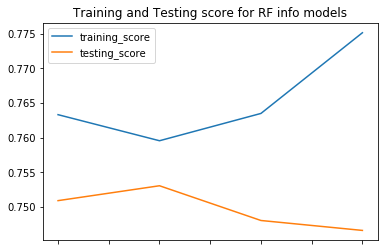

In [246]:
results.loc[['training_score','testing_score'],['RandomForestClassifier_info_1','RandomForestClassifier_info_2','RandomForestClassifier_info_3','RandomForestClassifier_info_5']].transpose().plot.line()
plt.title('Training and Testing score for RF info models')
plt.show()

## Best models and feature importances

In [247]:
#get best model overall for bogo,discount and info offers
best_model('bogo').append([best_model('discount'),best_model('info')]).transpose()

For bogo RF model:
For discount RF model:
For info RF model:


,RandomForestClassifier_bogo_3,RandomForestClassifier_discount_2,RandomForestClassifier_info_2
pred_time,0.048521,0.046996,0.017982
testing_score,0.828316,0.874656,0.753042
train_time,0.240407,0.234520,0.086053
training_score,0.846882,0.867570,0.759534


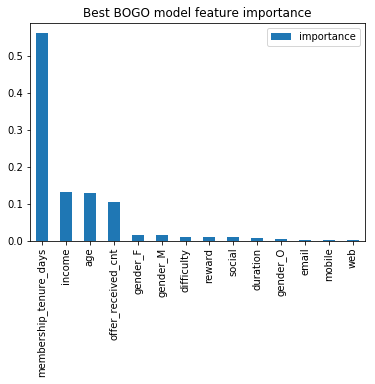

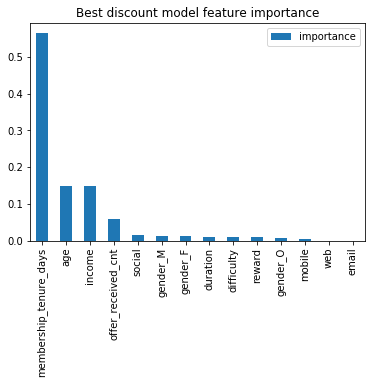

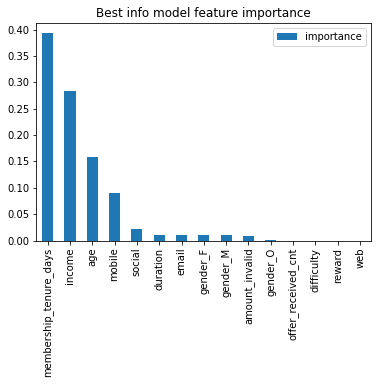

In [249]:
#show feature importance
#BOGO 3 model
#prepare data same as BOGO 3 state
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid']
features,target=data_prep(offers_bogo,drop_cols_prep)

feature_importances = pd.DataFrame(bogo_3.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
# print(feature_importances)
feature_importances.plot.bar()
plt.title('Best BOGO model feature importance')
plt.show()

#discount 3 model
feature_importances = pd.DataFrame(discount_3.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best discount model feature importance')
plt.show()

#info_2 model
#prepare data similar to info_2 state
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_discount,drop_cols_prep)
#print feature importance
feature_importances = pd.DataFrame(info_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best info model feature importance')
plt.show()